下载并调用EoN第三方库

In [110]:
!pip install EoN

随机生成一个复杂网络，20个节点，每两个节点连接的概率为0.3

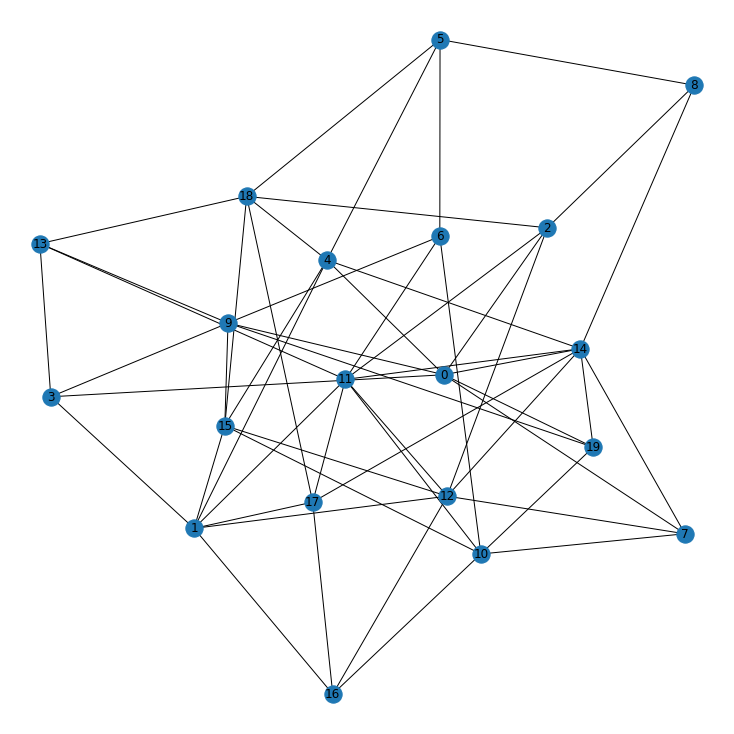

In [111]:
import networkx as nx
import matplotlib.pyplot as plt
g=nx.random_graphs.erdos_renyi_graph(20, 0.3)
plt.figure(figsize=(10,10))
nx.draw(g, with_labels = True)

进行SIR模拟，并画出随时间变化，S,I,R的变化，其中，传播概率为0.6，这里仅展示初始节点为0时的图像。

doing basic discrete SIR simulation
done with simulation, now plotting


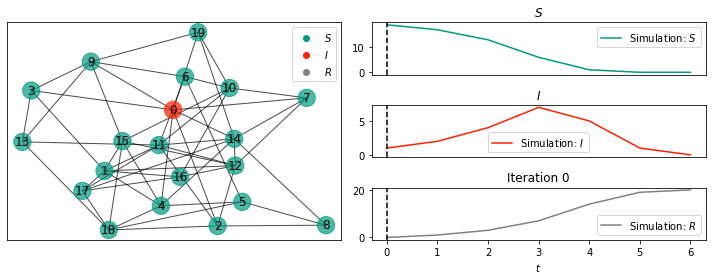

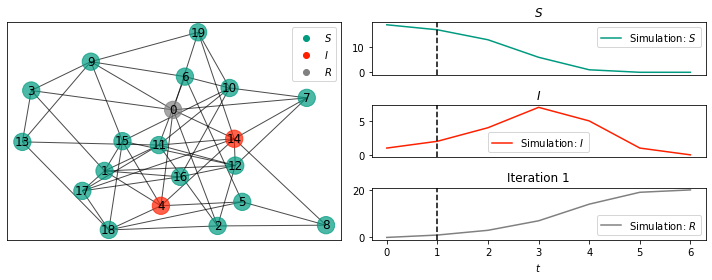

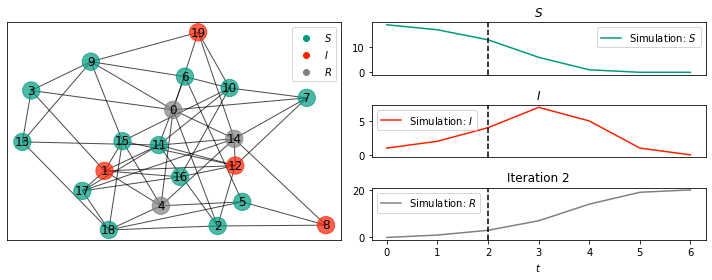

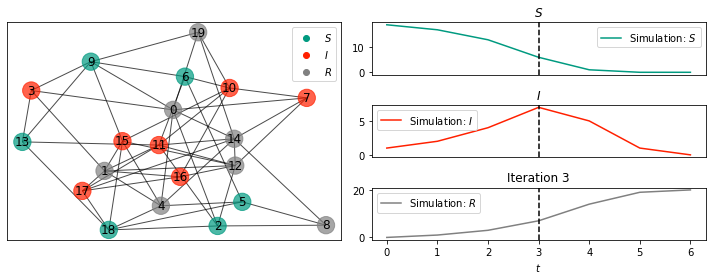

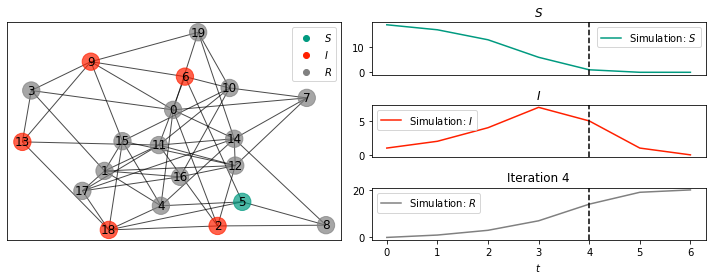

In [112]:
import EoN
pos = nx.spring_layout(g)
nx_kwargs = {"with_labels":True, "pos": pos, "alpha": 0.7}
print("doing basic discrete SIR simulation")
sim = EoN.basic_discrete_SIR(g, p=0.6, return_full_data=True, initial_infecteds=0)
print("done with simulation, now plotting")
for i in range(0,5,1):
  sim.display(time = i,  **nx_kwargs) 
  plt.title("Iteration {}".format(i))
  plt.draw()


下面这行代码提供了时间切片，可以通过修改time参数观察不同时间SIR模型的情况。

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6b5b227198>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f6b5afc0b00>])

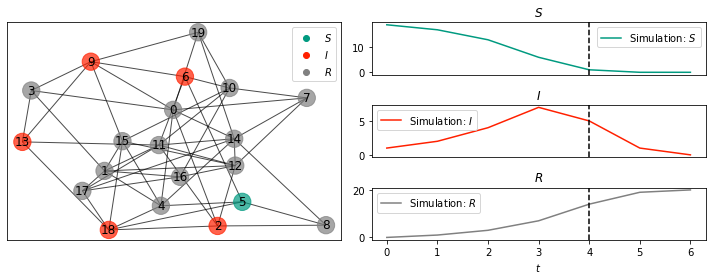

In [113]:
sim.display(time = 4,  **nx_kwargs)

下面这段代码仅仅是一个展示，画出S,I,R的返回值和其随时间的变化

<class 'numpy.ndarray'> [0 1 2 3 4 5]
<class 'numpy.ndarray'> [19 15  8  1  0  0]
<class 'numpy.ndarray'> [1 4 7 7 1 0]
<class 'numpy.ndarray'> [ 0  1  5 12 19 20]


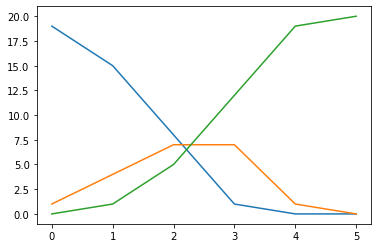

In [114]:
t, S, I, R = EoN.basic_discrete_SIR(g, 0.6, initial_infecteds=0)
plt.plot(t,S)
plt.plot(t,I)
plt.plot(t,R)
print(type(t),t)
print(type(S),S)
print(type(I),I)
print(type(R),R)

计算SIR模型模拟出的各个点的“重要性”矩阵，具体方法是运行十次SIR模型，取平均值

In [115]:
import numpy as np
arr_I = np.zeros((20,))
for i in range(20):
  for j in range(10):
    t, S, I, R = EoN.basic_discrete_SIR(g, 0.6, initial_infecteds=i)
    arr_I[i] = arr_I[i] + max(I) / 10

print(arr_I)

[7.8 8.  7.6 7.2 8.6 7.7 7.6 7.8 7.3 7.3 7.4 9.4 8.6 8.2 8.2 7.6 7.2 9.
 8.  7.5]


k-shell算法，计算20个节点的“重要性”矩阵



In [116]:
import numpy as np
def k_shell(G, u=None):
  _G = G.copy()
  # print(nx.info(_G))
  data = {}
  ks = 1
  while _G.nodes():
    # 暂存度为ks的顶点
    temp = []
    ns = {n:_G.degree[n] for n in _G.nodes()}
    # 每次删除度值最小的节点而不能删除度为ks的节点否则产生死循环。这也是这个算法存在的问题。
    kks = min(ns.values())
    while True:
      for k,v in ns.items():
        if v == kks:
          temp.append(k)
          _G.remove_node(k)
      ns = {n:_G.degree[n] for n in _G.nodes()}
      if kks not in ns.values():
        break
    data[ks] = temp
    ks += 1    
  return data

order=k_shell(g)
print(order)
kshell = np.zeros(20,)
for key, value in order.items():
  for i in range(20):
    if i in value:
      kshell[i]=key

print(kshell)

{1: [8, 5, 6], 2: [2, 3, 7, 13, 16, 19, 12, 17], 3: [9, 10, 18, 0, 11, 15, 4], 4: [1, 14]}
[3. 4. 2. 2. 3. 1. 1. 2. 1. 3. 3. 3. 2. 2. 4. 3. 2. 2. 3. 2.]


概率模型算法，计算20个节点的“重要性”矩阵

In [117]:
score=np.zeros(20,)
infected_prob=0.126
G=g
for i in range(20):
  prob=np.zeros(20,)
  s1_full=[n for n in G.neighbors(i)]
  s1_delete=list(set(s1_full).difference(set([i])))
  #print("s1")
  #print(s1_full, s1_delete)
  for j in s1_delete:
    prob[j]=0.126
    s2_full=[n for n in G.neighbors(j)]
    s2_delete=list(set(s2_full).difference(set(s1_full)))
    s2_delete=list(set(s2_delete).difference(set([i,j])))
    #print("s2")
    #print(s2_full, s2_delete)
    for k in s2_delete:
      prob[k]=prob[k]+0.016
      s3_full=[n for n in G.neighbors(k)]
      s3_delete=list(set(s3_full).difference(set(s1_full)))
      s3_delete=list(set(s3_delete).difference(set(s2_full)))
      s3_delete=list(set(s3_delete).difference(set([i,j,k])))
      #print("s3")
      #print(s3_full,s3_delete)
      for p in s3_delete:
        prob[p]=prob[p]+0.002
  #print(prob)
  for q in range(20):
    score[i]=score[i]+prob[q]

print(score)


[1.326 1.336 1.126 0.858 1.248 0.824 0.896 0.926 0.692 1.154 1.22  1.524
 1.354 0.902 1.492 1.284 0.88  1.082 1.214 0.91 ]


计算算法计算出的“重要性矩阵”和SIR模拟出来的“重要性矩阵”的相关性系数

In [120]:
import numpy as np
#相关性系数计算
n_positive = 0
n_negtive = 0
arr=score
for i in range(20):
  for j in range(20-i):
    if ((arr[i]<arr[i+j] and arr_I[i]<arr_I[i+j]) or (arr[i]>arr[i+j] and arr_I[i]>arr_I[i+j])):
      n_positive=n_positive+1
    elif ((arr[i]<arr[i+j] and arr_I[i]>arr_I[i+j]) or (arr[i]>arr[i+j] and arr_I[i]<arr_I[i+j])):
      n_negtive=n_negtive+1
    else:
      continue
relationship = (n_positive-n_negtive)/190
print(n_positive, n_negtive, relationship)

135 49 0.45263157894736844
